### Нас ждет прекрасный и поучительный анализ датафрейма - История и статистика массовой стрельбы в США с 1966 года (на самом деле людей там убивали и раньше в т.ч и присхопаты на улицах, но именно Техасский снайпер вошел в историю и публичную культуру как родоначальник массшутинга)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

Октрываем датафрейм и видим ужас. Ничего толкового тут пока не построить

In [2]:
mass_shootings_v5_df = pd.read_csv('Mass Shootings Dataset Ver 5.csv', encoding='cp1252')
mass_shootings_v5_df

,S#,Title,Location,Date,Incident Area,Open/Close Location,Target,Cause,Summary,Fatalities,...,Total victims,Policeman Killed,Age,Employeed (Y/N),Employed at,Mental Health Issues,Race,Gender,Latitude,Longitude
0,1,Texas church mass shooting,"Sutherland Springs, TX",11/5/2017,Church,Close,random,unknown,"Devin Patrick Kelley, 26, an ex-air force offi...",26,...,46,0.0,26,NaN,NaN,No,White,M,NaN,NaN
1,2,Walmart shooting in suburban Denver,"Thornton, CO",11/1/2017,Wal-Mart,Open,random,unknown,"Scott Allen Ostrem, 47, walked into a Walmart ...",3,...,3,0.0,47,NaN,NaN,No,White,M,NaN,NaN
2,3,Edgewood businees park shooting,"Edgewood, MD",10/18/2017,Remodeling Store,Close,coworkers,unknown,"Radee Labeeb Prince, 37, fatally shot three pe...",3,...,6,0.0,37,NaN,Advance Granite Store,No,Black,M,NaN,NaN
3,4,Las Vegas Strip mass shooting,"Las Vegas, NV",10/1/2017,Las Vegas Strip Concert outside Mandala Bay,Open,random,unknown,"Stephen Craig Paddock, opened fire from the 32...",59,...,585,1.0,64,NaN,NaN,Unclear,White,M,36.181271,-115.134132
4,5,San Francisco UPS shooting,"San Francisco, CA",6/14/2017,UPS facility,Close,coworkers,NaN,"Jimmy Lam, 38, fatally shot three coworkers an...",3,...,5,0.0,38,1.0,NaN,Yes,Asian,M,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,319,Clara Barton Elementary School,"Chicago, Illinois",1/17/1974,Clara Barton Elementary School,Close,Teachers,anger,"On January 17, 1974, a 14-year-old student ent...",1,...,4,0.0,14,NaN,NaN,Yes,Unknown,Male,41.839280,-87.688181
319,320,New Orleans Police Shootings,"New Orleans, Louisiana",12/31/1972,NaN,NaN,random,psycho,"On New Year's Eve in 1972, a 23-year-old ex-Na...",10,...,22,4.0,23,NaN,NaN,Yes,Black American or African American,Male,30.068724,-89.931474
320,321,St. Aloysius Church,"Spokane, Washington",11/11/1971,Church,Close,random,terrorism,"On November 11, 1971, a former MIT student ent...",2,...,5,0.0,NaN,NaN,NaN,Yes,White American or European American,Male,47.673674,-117.415984
321,322,Rose-Mar College of Beauty,"Mesa, Arizona",11/12/1966,Rose-Mar College of Beauty,Close,random,terrorism,"On November 12, 1966, an 18-year-old high scho...",5,...,6,0.0,18,NaN,NaN,Yes,White American or European American,Male,33.422687,-111.816320


Итак, перед нами данные о 323 случаях масовых убийств в США с 1966 по 2017 год. Посмотрим, что интересного мы из этого сможем извлечь. Это пятая версия файла, в которой количество инцедентов, по сравнению с первой меньше на 70+, зато намного больше данных. Качество фрейма, увы, таково, что на его приведение в божеский вид я угробил чуть ли не сутки. В конце концов я первый раз колупаю какие-то не учебные, а живые кривые НАСТОЛЬКО данные, пришлось немного подумать, как все это лучше оформить.

In [3]:
# Сначала выкинем не очень интересные вещи, такие как координаты и подробное описание инцидента
ms_v5_df = mass_shootings_v5_df.drop(mass_shootings_v5_df.columns[[0, 1, 5, 8, 15, 19, 20]], axis='columns')

In [4]:
ms_v5_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Location              278 non-null    object 
 1   Date                  323 non-null    object 
 2   Incident Area         261 non-null    object 
 3   Target                318 non-null    object 
 4   Cause                 246 non-null    object 
 5   Fatalities            323 non-null    int64  
 6   Injured               323 non-null    int64  
 7   Total victims         323 non-null    int64  
 8   Policeman Killed      317 non-null    float64
 9   Age                   179 non-null    object 
 10  Employeed (Y/N)       67 non-null     float64
 11  Mental Health Issues  323 non-null    object 
 12  Race                  321 non-null    object 
 13  Gender                323 non-null    object 
dtypes: float64(2), int64(3), object(9)
memory usage: 35.5+ KB


Прекрасно, у нас не определено не так уж много значений, сходу можно предположить, что в очень малом проценте случаев существующее официальное место работы убийцы в случае такого громкого преступления осталось неизвестным полиции и не было нигде опубликовано, с учетом того, что нам известны даже проблемы с психическим здоровьем стрелявшего. Таким образом, попробуем заполнить Employeed следующим образом - сочтем безработными (или, как минимум, не имеющими никакой стабильной легально оформленной работы) всех, у кого стоит NaN.  
Еще одна проблема - это причина атаки. Во многих случаях она указана как терроризм, при этом, понимаемый как любая атака против общества в целом с целью посеять страх и панику. Это более традиционное понимание тероризма, не имеющее отношения к современному исламскому терроризму, точнее, пересекающееся с ним лишь частично. Так что, стоит отметить, что когда мы читаем про Техасского Снайпера 1966 года - 'террорист', то в данной выборке это понимается не как маньяк-мусульманин, а как белый морпех, решивший навести ужас на улицы города. Однако, при этом, стрельба в Новом Орлеане 1972 г. отмечена как "психопатия", хотя Чарльз Уитмен был не меньшим психопатом да еще и с опухолью мозга. В итоге эта графа вообще очень странная, попробуем ее исправить следующим образом. Заменим терроризм на психопатию, если в графе "Mental Health Issues" стоит Да.  
Также проведем косметические правки, например, не углубляясь в тонкие расовые различия между Черными и Афроамериканцами обзовем их кучей черными и так далее. Также заменим NaN на более корректное для дальнейшего анализа Unknown.

In [5]:
# Замена NaNов
ms_v5_df['Employeed (Y/N)'].fillna(0, inplace=True)
ms_v5_df['Cause'].fillna('Unknown', inplace=True)
ms_v5_df['Target'].fillna('Unknown', inplace=True)
ms_v5_df['Race'].fillna('Unknown', inplace=True)
ms_v5_df['Location'].fillna('Unknown', inplace=True)
ms_v5_df['Policeman Killed'].fillna(0, inplace=True)
ms_v5_df['Incident Area'].fillna('Unknown', inplace=True)
ms_v5_df['Age'].fillna('Unknown', inplace=True)
# Косметические правки (т.к любого настоящего американца вопрос правильного вычисления и указания РАСЫ 
# волнует больше чем Гиммлера, то в оной графе там настоящий треш, приведем 
# все к стандарту Белый/Черный/Азиат/Индеец/Латинос)
ms_v5_df['Race'] = ms_v5_df['Race'].mask((ms_v5_df['Race'] == 'Two or more races'), 'Unknown')
ms_v5_df['Race'] = ms_v5_df['Race'].mask((ms_v5_df['Race'] == 'Black American or African American/Unknown'), 'Black')
ms_v5_df['Race'] = ms_v5_df['Race'].mask((ms_v5_df['Race'] == 'White American or European American/Some other...'), 'White')
ms_v5_df['Race'] = ms_v5_df['Race'].mask((ms_v5_df['Race'] == 'Native American or Alaska Native'), 'Native')
ms_v5_df['Race'] = ms_v5_df['Race'].mask((ms_v5_df['Race'] == 'Asian American/Some other race'), 'Asian')
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'White American or European American', 'White', ms_v5_df['Race'])
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'white', 'White', ms_v5_df['Race'])
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'black', 'Black', ms_v5_df['Race'])
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'Black American or African American', 'Black', ms_v5_df['Race'])
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'Asian American', 'Asian', ms_v5_df['Race'])
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'Some other race', 'Other', ms_v5_df['Race'])
ms_v5_df['Race'] = np.where(ms_v5_df['Race'] == 'Other', 'Unknown', ms_v5_df['Race'])
# аналогично с гендером
ms_v5_df['Gender'] = np.where(ms_v5_df['Gender'] == 'Male', 'M', ms_v5_df['Gender'])
ms_v5_df['Gender'] = np.where(ms_v5_df['Gender'] == 'Female', 'F', ms_v5_df['Gender'])
ms_v5_df['Gender'] = np.where(ms_v5_df['Gender'] == 'M/F', 'M + F', ms_v5_df['Gender'])
ms_v5_df['Gender'] = np.where(ms_v5_df['Gender'] == 'Male/Female', 'M + F', ms_v5_df['Gender'])
ms_v5_df['Mental Health Issues'] = np.where(ms_v5_df['Mental Health Issues'] == 'Unclear', 'Unknown', ms_v5_df['Mental Health Issues'])
# Предположим, что все неизвестные нам по полу нападавшие - мужчины (т.к в 99% так и есть)
ms_v5_df['Gender'] = np.where(ms_v5_df['Gender'] == 'Unknown', 'M', ms_v5_df['Gender'])
# Почистим причины, далее мы еще подробно с ними разберемся
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'unknown'), 'Unknown')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'terrorism')&(ms_v5_df['Mental Health Issues'] == 'Yes'), 'psycho')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'racism')&(ms_v5_df['Race'] == 'Black'), 'Black racism')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'racism')&(ms_v5_df['Race'] == 'White'), 'White racism')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'frustration'), 'Psycho')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'psycho'), 'Psycho')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'terrorism')&(ms_v5_df['Race'] == 'Black'), 'Psycho')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'terrorism')&(ms_v5_df['Race'] == 'Unknown'), 'Unknown')
ms_v5_df['Cause'] = np.where(ms_v5_df['Cause'] == 'unemployement', 'Unknown', ms_v5_df['Cause'])

# Заменим даты в американской системе на год ибо анализировать массшутинг за 60 лет помесячно нам не интересно
def date_change(string):
    year = r'\d{1,2}/\d{1,2}/(\d{4})'
    replace = r'\1'
    return re.sub(year, replace, string)

ms_v5_df['Date'] = ms_v5_df['Date'].apply(date_change)

# Заменим локации на почтовые коды, там где это нужно
def location_change_1(string):
    year = r'[^,]*, (\w{2})'
    replace = r'\1'
    return re.sub(year, replace, string)

def location_change_2(string):
    year = r'[^,]*, (\w*)'
    replace = r'\1'
    return re.sub(year, replace, string) 

ms_v5_df['Location'] = ms_v5_df['Location'].apply(location_change_1)
ms_v5_df['Location'] = ms_v5_df['Location'].apply(location_change_2)

# Заменим почтовые коды штатов на штаты
zip_code_state = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
            'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York,', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

def zip_code(string):
    if string in zip_code_state.keys():
        string = zip_code_state[string]
    return string

ms_v5_df['Location'] = ms_v5_df['Location'].apply(zip_code)

ms_v5_df.head()


,Location,Date,Incident Area,Target,Cause,Fatalities,Injured,Total victims,Policeman Killed,Age,Employeed (Y/N),Mental Health Issues,Race,Gender
0,Texas,2017,Church,random,Unknown,26,20,46,0.0,26,0.0,No,White,M
1,Colorado,2017,Wal-Mart,random,Unknown,3,0,3,0.0,47,0.0,No,White,M
2,Maryland,2017,Remodeling Store,coworkers,Unknown,3,3,6,0.0,37,0.0,No,Black,M
3,Nevada,2017,Las Vegas Strip Concert outside Mandala Bay,random,Unknown,59,527,585,1.0,64,0.0,Unknown,White,M
4,California,2017,UPS facility,coworkers,Unknown,3,2,5,0.0,38,1.0,Yes,Asian,M


Вообще с этим датафреймом возни немеряно, для приведения его в божеский вид. Но таки интересно, что у нас в итоге получится. Давайте теперь заменим Incident Area на четкие категории. 

In [6]:
ms_v5_df['Incident Area'] = ms_v5_df['Incident Area'].mask(((ms_v5_df['Target'] == 'coworkers')|(ms_v5_df['Target'] == "Coworker's")|(ms_v5_df['Target'] == 'Ex-Coworkers')|(ms_v5_df['Target'] =='Workers')), 'Workplace')
                                                                                                                                                                                                                                                                    
                                                                                                  
def clean_area(str_):
    test_street = ['sidewalk', 'strip', 'outside', 'drive-by', 'park', 'bridge', 'highway', 'backyard', 'parking', 'street', 'Bay', 'Square', 'protest']
    test_house = ['Apartment', 'apartment', 'neighborhood', 'home', 'Home', 'Apartments', 'house']
    test_church = ['Monastery', 'Temple', 'Church', 'Center+Church']
    test_public_places = ['Courthouse', 'Theatre', 'club', 'Train', 'Spa', 'Shop', 'Shopping', 'Salon', 'Restaurant', 'Pub', 'Public', 'Mall', 'Home+Stock', 'Home+Restaurant', 'Hall', 'Hair', 'Café+Walmart', 'Coffee', 'Cafeteria', 'Bus', 'Beauty', 'Airport', 'airport', 'Barber', 'Wal-Mart', 'walmart', 'store', 'station', 'bus', 'barber', 'shop', 'nightclub', 'Club', 'restaurant']
    test_univercity = ['fraternity', 'conference', 'campus', 'University', 'Dormitory', 'Lecture', 'Academy', 'Campus']
    test_post = ['Post', 'post']
    test_workplace = ['Factory', 'Company', 'Office', 'firm', 'company', 'office', 'Workplace']
    test_party = ['Party', 'birthday', 'dance', 'party', 'private']
    test_healtcare = ['Health', 'clinic', 'health', 'hospital']
    test_college = ['High', 'College', 'of']
    test_school = ['Classroom', 'Home+School', 'Scool', 'School']
    list_ = str_.split()
    if set(list_)&set(test_street):
        return 'Street'
    elif set(list_)&set(test_house):
        return 'House'
    elif set(list_)&set(test_church):
        return 'Church'
    elif set(list_)&set(test_public_places):
        return 'Public places'
    elif set(list_)&set(test_univercity):
        return 'University'
    elif set(list_)&set(test_post):
        return 'Post'
    elif set(list_)&set(test_workplace):
        return 'Workplace'
    elif set(list_)&set(test_party):
        return 'Party'       
    elif set(list_)&set(test_healtcare):
        return 'Healtcare'
    elif set(list_)&set(test_college):
        return 'College'
    elif set(list_)&set(test_school):
        return 'School'
    
ms_v5_df['Incident Area'] = ms_v5_df['Incident Area'].apply(clean_area)     
ms_v5_df['Incident Area'].replace('None', np.nan, inplace=True)
ms_v5_df['Incident Area'].fillna('Other', inplace=True)  

Теперь все практически идеально, для полноты картины осталось разобраться с жертвами и причинами. Беглый анализ показал, что мы имеем вот такую кучу категорий, это никуда не годится

In [7]:
list_ = ' '.join(list(ms_v5_df['Cause']))
set(list_.split())

{'Black',
 'Psycho',
 'Unknown',
 'White',
 'anger',
 'breakup',
 'dispute',
 'disputer',
 'domestic',
 'drunk',
 'exams',
 'failing',
 'racism',
 'radicalism',
 'religious',
 'revenge',
 'robbery',
 'suspension',
 'terrorism'}

In [8]:
# Почистим все это безобразие
def clean_target(str_):
    test_ex = ['Ex-Girlfriend', 'Ex-Girlfriend+random', 'Girlfriend', "partner's"]
    test_army = ['Trooper', 'Marines']
    test_school = ['Children', 'Family+students', 'Students', 'Students+Parents', 'Students+Teachers', 'Teachers', 'school']
    test_family = ['House', 'Family', 'Family+random', 'family', 'Family/Neighbors']
    test_neighbors = ['Friends', 'neighbors']
    test_police = ['police', 'Officer', 'Policeman', 'Policeman+Council']
    test_party = ['club', 'guests', 'members', 'birthday', 'party', 'uninvited']
    test_bl = ['black']
    test_girl = ['girls', 'women']
    test_rnd = ['random', 'rapper+random']
    list_ = str_.split()
    if set(list_)&set(test_ex):
        return "Ex- or partner's"
    elif set(list_)&set(test_army):
        return 'Army'
    elif set(list_)&set(test_school):
        return 'Students and Teachers'
    elif set(list_)&set(test_family):
        return 'Family'
    elif set(list_)&set(test_neighbors):
        return 'Friends or neighbors'
    elif set(list_)&set(test_police):
        return 'Police'
    elif set(list_)&set(test_party):
        return 'Party'
    elif set(list_)&set(test_bl):
        return 'Black'       
    elif set(list_)&set(test_girl):
        return 'Women'
    elif set(list_)&set(test_rnd):
        return 'Random'

# И причины тоже, как по сути, так и косметически
ms_v5_df['Target'] = ms_v5_df['Target'].apply(clean_target)     
ms_v5_df['Target'].replace('None', np.nan, inplace=True)
ms_v5_df['Target'].fillna('Random', inplace=True)  
ms_v5_df['Target'] = ms_v5_df['Target'].mask((ms_v5_df['Incident Area'] == 'Church'), 'Congregation')
ms_v5_df['Target'] = ms_v5_df['Target'].mask((ms_v5_df['Incident Area'] == 'Workplace'), 'Coworkers')
ms_v5_df['Target'] = ms_v5_df['Target'].mask((ms_v5_df['Cause'] == 'Black racism'), 'White')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'terrorism'), 'Religious')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'anger'), 'Anger')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'domestic dispute'), 'Dispute')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'domestic disputer'), 'Dispute')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'religious radicalism'), 'Religious')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'revenge'), 'Revenge')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'religious'), 'Religious')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'radicalism'), 'Religious')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'failing exams'), 'Anger')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'suspension'), 'Psycho')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'breakup'), 'Psycho')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'drunk'), 'Drunk')
ms_v5_df['Cause'] = ms_v5_df['Cause'].mask((ms_v5_df['Cause'] == 'Radicalism'), 'Religious')

#df.drop(df.index[[1,3]])
row = ms_v5_df.loc[ms_v5_df['Cause'] == 'robbery']
row

,Location,Date,Incident Area,Target,Cause,Fatalities,Injured,Total victims,Policeman Killed,Age,Employeed (Y/N),Mental Health Issues,Race,Gender
289,Arizona,1991,Church,Congregation,robbery,9,0,9,0.0,Unknown,0.0,No,Asian,M


In [9]:
# выкинем ограбление
ms_v5_df = ms_v5_df.drop(ms_v5_df.index[[289]])
# и учтем, что грохнувший своих коворкеров определенно ходил на работу
ms_v5_df['Employeed (Y/N)'] = ms_v5_df['Employeed (Y/N)'].mask(ms_v5_df['Target'] == 'Coworkers', 1)
# и приведем все к целым
ms_v5_df_clean = ms_v5_df.astype('int', errors='ignore')
ms_v5_df_clean

,Location,Date,Incident Area,Target,Cause,Fatalities,Injured,Total victims,Policeman Killed,Age,Employeed (Y/N),Mental Health Issues,Race,Gender
0,Texas,2017,Church,Congregation,Unknown,26,20,46,0,26,0,No,White,M
1,Colorado,2017,Public places,Random,Unknown,3,0,3,0,47,0,No,White,M
2,Maryland,2017,Workplace,Coworkers,Unknown,3,3,6,0,37,1,No,Black,M
3,Nevada,2017,Street,Random,Unknown,59,527,585,1,64,0,Unknown,White,M
4,California,2017,Workplace,Coworkers,Unknown,3,2,5,0,38,1,Yes,Asian,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,Illinois,1974,School,Students and Teachers,Anger,1,3,4,0,14,0,Yes,Unknown,M
319,Louisiana,1972,Other,Random,Psycho,10,13,22,4,23,0,Yes,Black,M
320,Washington,1971,Church,Congregation,Psycho,2,4,5,0,Unknown,0,Yes,White,M
321,Arizona,1966,Public places,Random,Psycho,5,1,6,0,18,0,Yes,White,M


Теперь мы имеем прекрасный файл, в котором все почистили и заменили более-менее единообразно. Вообще беглый просмотр исходника говорит, что данные довольно некачественные, то есть во многих местах Location указана в подробном описании, но не распарсилась и не вошла в датафрейм, в некоторых местах указан не классический психопатический массакр а-ля Колумбайн или Остин (а нас интерсуют именно они), а типичный гангстерский драйв-бай, следовательно, встает вопрос правомочности вхождения этого эпизода в статистику именно массовых убийств, а не криминальных разорок, и так далее.  
Но фрейма лучше, увы, я не нашел.

### Все готово, начнем рисовать

In [10]:
# Подсчитаем убиенных за каждый год
year_fatalities_dict = {}
for index, row in ms_v5_df_clean.iterrows():
    year = (ms_v5_df_clean['Date'] == row['Date'])
    year_fatalities = ms_v5_df_clean[year]
    fatalities_sum = year_fatalities['Fatalities'].sum()
    year_fatalities_dict.setdefault(row['Date'], fatalities_sum)

# и раненых

year_injured_dict = {}
for index, row in ms_v5_df_clean.iterrows():
    year = (ms_v5_df_clean['Date'] == row['Date'])
    year_fatalities = ms_v5_df_clean[year]
    fatalities_sum = year_fatalities['Injured'].sum()
    year_injured_dict.setdefault(row['Date'], fatalities_sum)
    
# для совместимости списков с числом убитых добавим 0 в 2000 год, где не было раненых
year_injured_dict['2000'] = 0

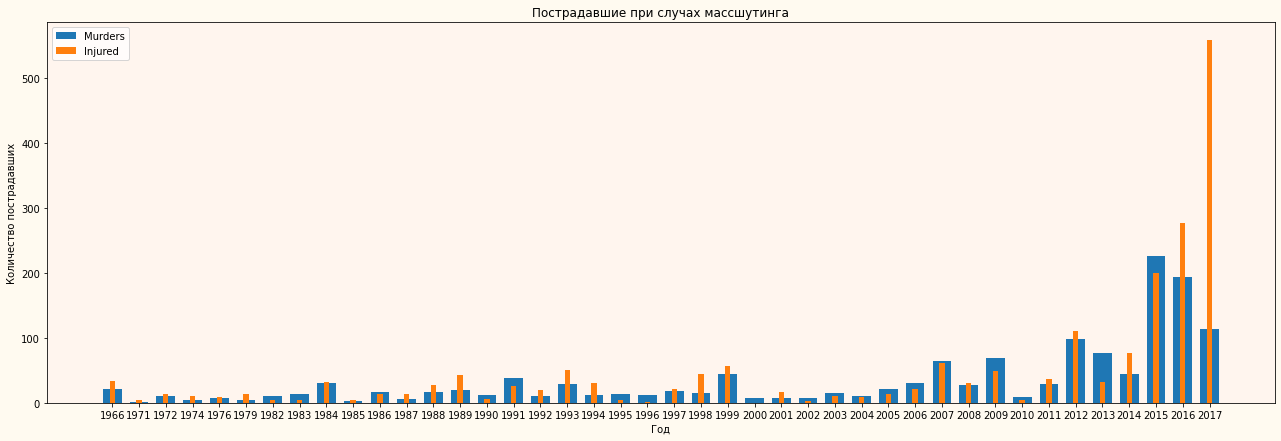

In [11]:

dates = list(reversed(list(year_fatalities_dict.keys())))
murders = list(reversed(list(year_fatalities_dict.values())))
injured = list(reversed(list(year_injured_dict.values())))

fig, ax = plt.subplots()

ax.bar(dates, murders, width = 0.7, label="Murders")
ax.bar(dates, injured, width = 0.2, label="Injured")
ax.legend()


ax.set_facecolor('seashell')
fig.set_figwidth(22)    #  ширина Figure
fig.set_figheight(7)    #  высота Figure
fig.set_facecolor('floralwhite')

plt.title('Пострадавшие при случах массшутинга')
plt.xlabel('Год')
plt.ylabel('Количество пострадавших')
plt.show()


Text(0, 0.5, 'Количество пострадавших')

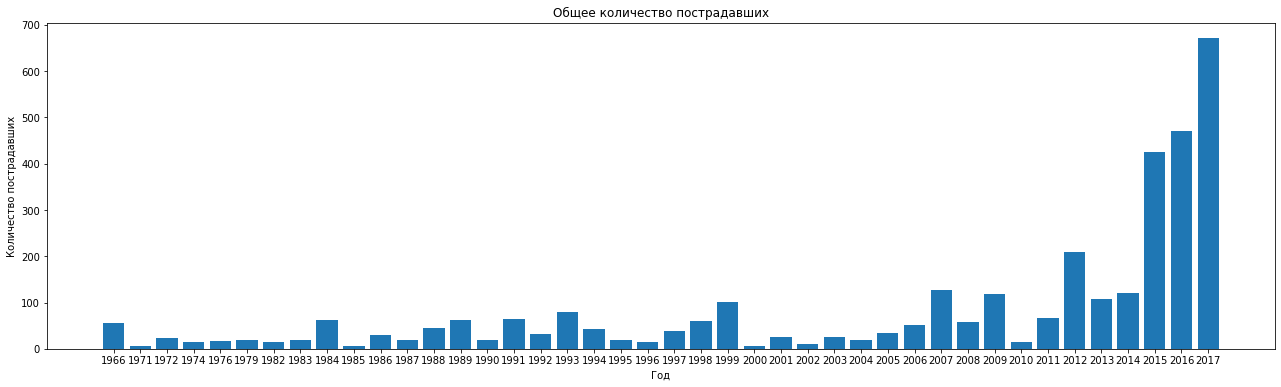

In [12]:
casualties = [x+y for x, y in zip(murders, injured)]
from pylab import rcParams
rcParams['figure.figsize'] = 22,6
plt.bar(dates, casualties)
plt.title('Общее количество пострадавших')
plt.xlabel('Год')
plt.ylabel('Количество пострадавших')

На самом деле эти графики нам мало что говорят, ибо мы не учли мирные годы без жертв

Text(0, 0.5, 'Количество пострадавших')

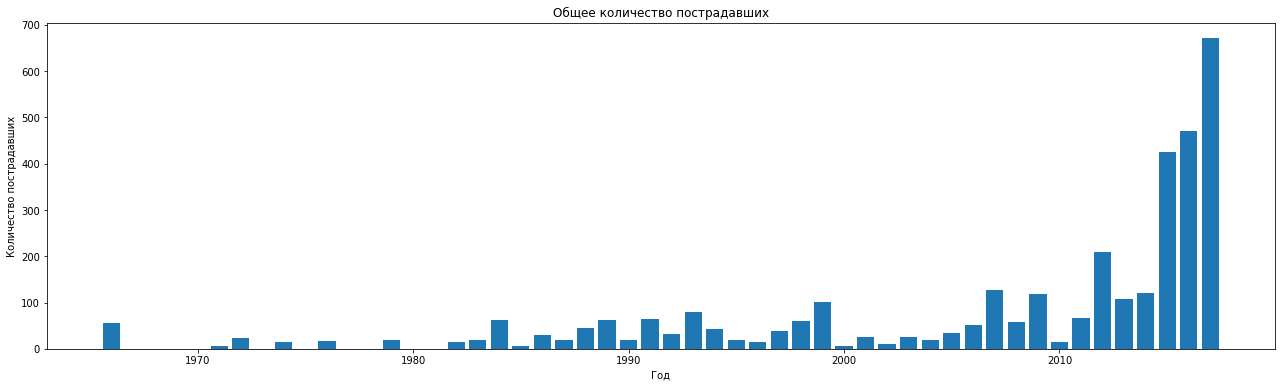

In [13]:
# для полноты картины добавим на график те годы, в которые ничего не произошло
dates_full = ([i for i in range(1966, 2018)])
murders_full = []
for i in range(0, len(dates_full)):
    x = str(dates_full[i])
    if x in dates:
        murders_full.append(murders[dates.index(x)])
    else:
        murders_full.append(0)

injured_full = []
for i in range(0, len(dates_full)):
    x = str(dates_full[i])
    if x in dates:
        injured_full.append(injured[dates.index(x)])
    else:
        injured_full.append(0)
        
casualties_full = [x+y for x, y in zip(murders_full, injured_full)]

plt.bar(dates_full, casualties_full)
plt.title('Общее количество пострадавших')
plt.xlabel('Год')
plt.ylabel('Количество пострадавших')

На самом деле ОЧЕНЬ интересный график, для интерпретации которого можно углубится в историю,экономику, политику и социологию США. Четко видно, что до середины 80-х массовые убийства не были чем-то рядовым и случались чрезвычайно редко. Первый горб приходится на конец 80 (конец рейганомики), далее примерно с интервалом 10 лет - кризис в России 1998 и обвал рынков по всему миру, кризис 2008, а начиная с 2010 вообще полный мрак и чем дальше тем хуже. На эту тему можно написать целую статью, довольно серьезную, у меня есть мысли на этот счет, но поля слишком узки, что бы все их вместить)     

In [14]:
# найдем медианный год
median_casualties = int(sum(casualties_full)/2)
median_casualties
# половина пострадавших

1709

In [15]:
def date_median():
    median_casualties_by_years = 0
    for i in dates_full:
        date_ = 1966
        while median_casualties_by_years < median_casualties: 
            date_ += 1
            median_casualties_by_years += casualties_full[dates_full.index(i)]
        else:
            return date_ 
date_median()     

1998

Итак, с 1966 по 1998 пострадало столько же народу, сколько с 1999 по 2017

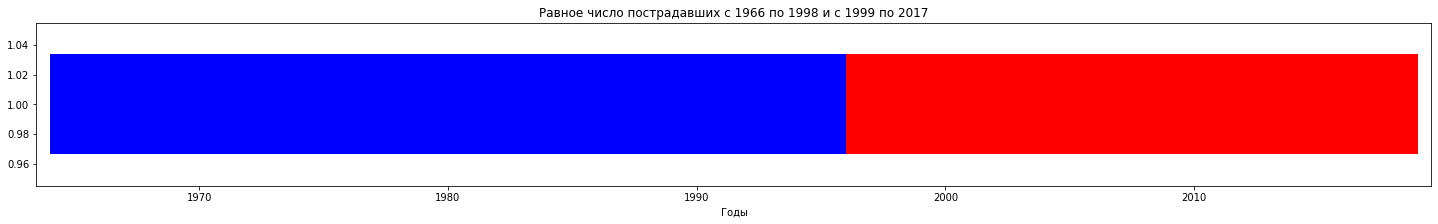

In [16]:
dates_low = [i for i in range(1966, date_median()+1)]
range_low = np.ones(date_median() - dates_full[0]+1)
dates_upper = [i for i in range(date_median(), 2018)]
range_upper = np.ones(len(dates_full) - (date_median() - dates_full[0]))


fig, axes = plt.subplots(figsize=(25,3))
axes.plot(dates_low, range_low, color='b', linewidth=100, linestyle='-')
axes.plot(dates_upper, range_upper, color='r', linewidth=100, linestyle='-')
axes.set_xlabel('Годы')
axes.set_title('Равное число пострадавших с 1966 по 1998 и с 1999 по 2017');



Обратите внимание, это не горизонтальный столбик с накоплением (чет он мне показался ну слишком замороченным в данных условиях, а его хитрая эмуляция обычным плотом, смотрится неплохо!

Давайте поработаем с расовым составом убийц. Как мне кажется, это редкий случай, когда диаграмма-пирожок (да еще и покрашенная в расово-верные цвета) довольно выразительна и дает представление о качественной динамике.

(-1.1078872377485254,
 1.1003756060798342,
 -1.1024865866434046,
 1.126858382289491)

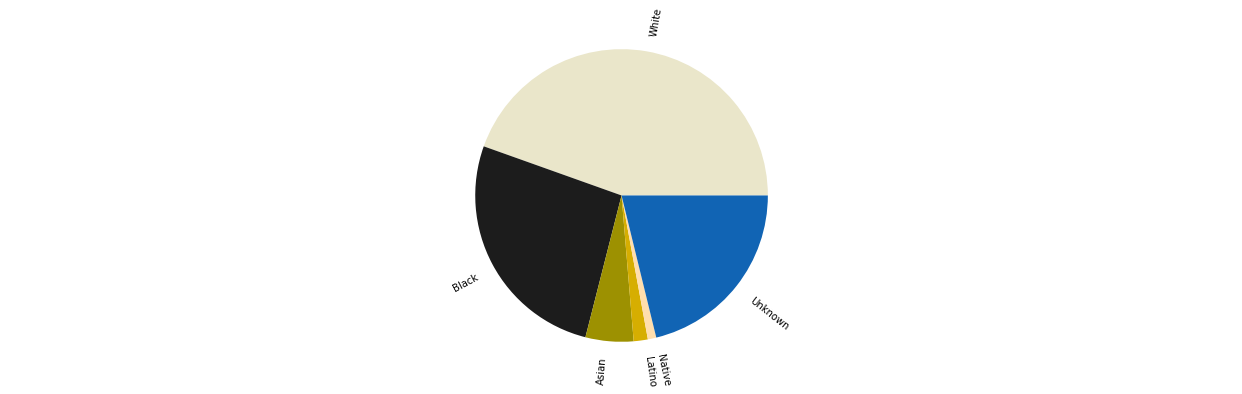

In [17]:
white = 0
black = 0
asian = 0
latino = 0
native = 0
unknown = 0

for index, row in ms_v5_df_clean.iterrows():
    if row['Race'] == 'White':
        white += 1
    elif row['Race'] == 'Black':
        black += 1
    elif row['Race'] == 'Asian':
        asian += 1
    elif row['Race'] == 'Latino':
        latino += 1
    elif row['Race'] == 'Native':
        native += 1
    elif row['Race'] == 'Unknown':
        unknown += 1
race_list = [white, black, asian, latino, native, unknown]
race_list_names = ['White', 'Black', 'Asian', 'Latino', 'Native', 'Unknown']
race_list_color = ['#EAE6CA', '#1C1C1C', '#9D9101', '#D6AE01', '#FFDEAD', '#1164B4']

fig, ax = plt.subplots()
ax.pie(race_list, labels=race_list_names, colors = race_list_color, rotatelabels=True)
ax.axis("equal")

Тепрь поработаем с возрастом, ради разнообразия для него построим боксплот

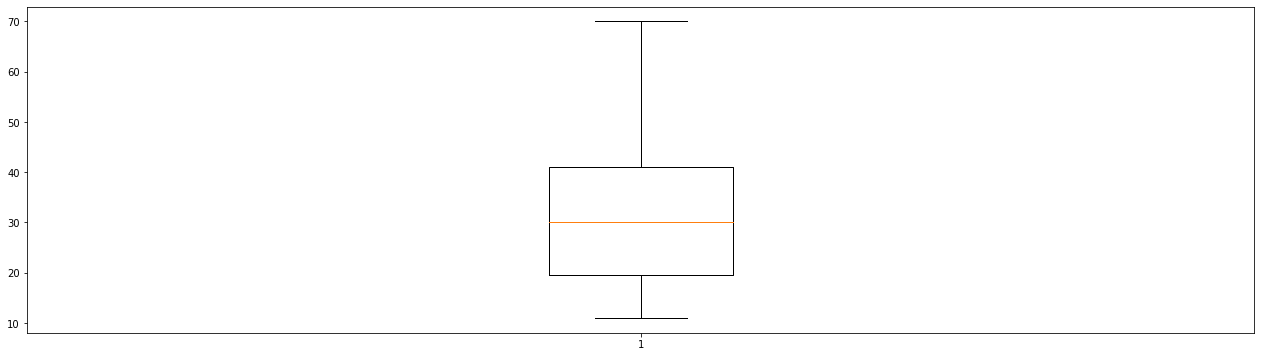

In [18]:
# с аозрастом вылезла засада, мало того, что тип данных в тсолбце оказался str, так еще и в 
# нескольких местах он оказался указан как '19,32' и тп (а в одном месте эти наркоманы вообще поставили НОЛЬ!!)
# придется все сначала приводить к нормальному виду

# этот мрак меня уже довел окончательно и я слил все даты в мегастроку, а потом тремя регулярками
# вычистил нафиг все, что мне мешало жить и конвертировал результат в простой нормальный список

def clean_age(string):
    subst_1 = r'Unknown'
    replace_1 = r' '
    reg_1 = re.sub(subst_1, replace_1, string)
    subst_2 = r' 0 '
    replace_2 = r' '
    reg_2 = re.sub(subst_2, replace_2, reg_1)
    subst_3 = r','
    replace_3 = r' '
    reg_3 = re.sub(subst_3, replace_3, reg_2)
    return reg_3.split()

age = [int(clean_age(' '.join(list(ms_v5_df_clean['Age'])))[i]) for i in range(0, len(clean_age(' '.join(list(ms_v5_df_clean['Age'])))))]

plt.boxplot(age)
plt.show()


И вот он, вожделенный боксплот!!

По тому же возрасту построим-ка мы еще и гистограмму

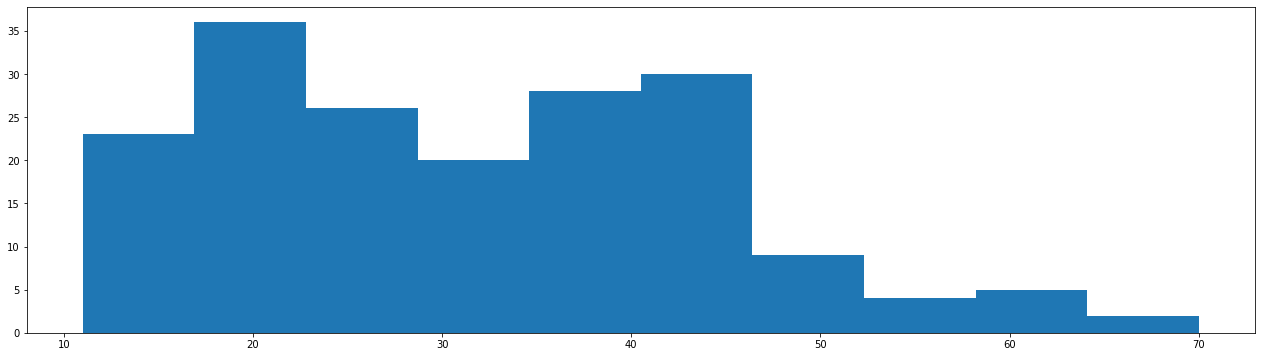

In [19]:
plt.hist(age)
plt.show()

Теперь поработаем с причинами

In [20]:
list_area = list(set(list(ms_v5_df_clean['Incident Area'])))
list_target = list(set(list(ms_v5_df_clean['Target'])))
list_cause = list(set(list(ms_v5_df_clean['Cause'])))
list_date = list(set(list(ms_v5_df_clean['Date'])))

In [32]:
# Перетолмачим весь наш датафрейм в несколько. Вот датафрейм с местами по годам

frame_dict_area = {}
frame_list_area =[]
i = 0
for date in list_date:
    mask = ms_v5_df_clean['Date'] == date
    df = ms_v5_df_clean[mask]
    area_dict = {}
    area_dict.setdefault('Date', int(date))
    area_count = 0
    for area in list_area:
        mask = (df['Incident Area'] == area)
        df_area = df[mask]
        area_count = len(list(df_area['Incident Area']))
        area_dict.setdefault(area, area_count)
    frame_dict_area.setdefault(i, area_dict)
    frame_list_area.append(frame_dict_area)
    i += 1
    area_dict = {}
    frame_dict_area ={}

area_df = pd.concat([pd.DataFrame(l) for l in frame_list_area],axis=1).T   
neworder = ['Date', 'Church', 'College', 'Healtcare', 'House', 'Party', 'Post', 'School', 'Street', 'University', 'Workplace', 'Public places', 'Other']
area_df = area_df.reindex(columns=neworder)
area_df['Date'] = pd.to_numeric(area_df['Date'])
area_df.sort_values('Date').head()


,Date,Church,College,Healtcare,House,Party,Post,School,Street,University,Workplace,Public places,Other
7,1966,0,0,0,0,0,0,0,0,1,0,1,0
16,1971,1,0,0,0,0,0,0,0,0,0,0,0
30,1972,0,0,0,0,0,0,0,0,0,0,0,1
37,1974,0,0,0,0,0,0,1,0,0,0,0,1
25,1976,0,0,0,0,0,0,1,0,1,0,0,0


Великолепно! Проделаем тоже самое с причинами и жертвами 

In [36]:
frame_dict_target = {}
frame_list_target =[]
i = 0
for date in list_date:
    mask = ms_v5_df_clean['Date'] == date
    df = ms_v5_df_clean[mask]
    target_dict = {}
    target_dict.setdefault('Date', int(date))
    target_count = 0
    for target in list_target:
        mask = (df['Target'] == target)
        df_target = df[mask]
        target_count = len(list(df_target['Target']))
        target_dict.setdefault(target, target_count)
    frame_dict_target.setdefault(i, target_dict)
    frame_list_target.append(frame_dict_target)
    i += 1
    target_dict = {}
    frame_dict_target ={}

target_df = pd.concat([pd.DataFrame(l) for l in frame_list_target],axis=1).T 
neworder = ['Date', 'Army', 'Black', 'Congregation', 'Coworkers', "Ex- or partner's", 'Family', 'Friends or neighbors', 'Party', 'Police', 'Random', 'Students and Teachers', 'White', 'Women']
target_df = target_df.reindex(columns=neworder)
target_df['Date'] = pd.to_numeric(target_df['Date'])
target_df.sort_values('Date').head()

,Date,Army,Black,Congregation,Coworkers,Ex- or partner's,Family,Friends or neighbors,Party,Police,Random,Students and Teachers,White,Women
7,1966,0,0,0,0,0,0,0,0,0,2,0,0,0
16,1971,0,0,1,0,0,0,0,0,0,0,0,0,0
30,1972,0,0,0,0,0,0,0,0,0,1,0,0,0
37,1974,0,0,0,0,0,0,0,0,0,1,1,0,0
25,1976,0,0,0,0,0,0,0,0,0,1,1,0,0


In [40]:
frame_dict_cause = {}
frame_list_cause =[]
i = 0
for date in list_date:
    mask = ms_v5_df_clean['Date'] == date
    df = ms_v5_df_clean[mask]
    cause_dict = {}
    cause_dict.setdefault('Date', int(date))
    cause_count = 0
    for cause in list_cause:
        mask = (df['Cause'] == cause)
        df_cause = df[mask]
        cause_count = len(list(df_cause['Cause']))
        cause_dict.setdefault(cause, cause_count)
    frame_dict_cause.setdefault(i, cause_dict)
    frame_list_cause.append(frame_dict_cause)
    i += 1
    cause_dict = {}
    frame_dict_cause ={}
    
cause_df = pd.concat([pd.DataFrame(l) for l in frame_list_cause],axis=1).T 
neworder = ['Date', 'Anger', 'Black racism', 'Dispute', 'Drunk', 'Psycho', 'Religious', 'Revenge', 'Unknown', 'White racism']
cause_df = cause_df.reindex(columns=neworder)
cause_df['Date'] = pd.to_numeric(cause_df['Date'])
cause_df.sort_values('Date').head()

,Date,Anger,Black racism,Dispute,Drunk,Psycho,Religious,Revenge,Unknown,White racism
7,1966,0,0,0,0,2,0,0,0,0
16,1971,0,0,0,0,1,0,0,0,0
30,1972,0,0,0,0,1,0,0,0,0
37,1974,1,0,0,0,0,1,0,0,0
25,1976,1,0,0,0,1,0,0,0,0


Ееее, теперь все готово еще для парочки графиков

In [47]:
church = sum(area_df['Church'])
college = sum(area_df['College'])
healtcare = sum(area_df['Healtcare'])
house = sum(area_df['House'])
party = sum(area_df['Party'])
post = sum(area_df['Post'])
school = sum(area_df['School'])
street = sum(area_df['Street'])
university = sum(area_df['University'])
workplace = sum(area_df['Workplace'])
public_places = sum(area_df['Public places'])
other = sum(area_df['Other']

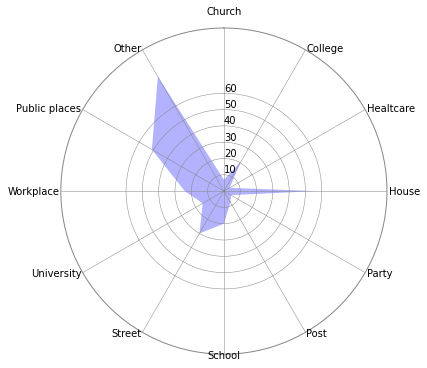

In [55]:
# Честно скажу, идею этой красоты я подсмотрел, но пришлось ее немного поправить

category = ['Church', 'College', 'Healtcare', 'House', 'Party', 'Post', 'School', 'Street', 'University', 'Workplace', 'Public places', 'Other']
values = [church, college, healtcare, house, party, post, school, street, university, workplace, public_places, other]

def roung_graph(category, values):
    N = len(category)
    x_as = [n / float(N) * 2 * np.pi for n in range(N)]
    # Связываем последнее значение с первым чтобы построить радиальный график
    values += values[:1]
    x_as += x_as[:1]
    # Устанавливаем цвет и толщину линий
    plt.rc('axes', linewidth = 1, edgecolor = "#888888")
    # Создаем диаграмму
    ax = plt.subplot(111, polar=True)
    # Убираем стандартные метки
    plt.xticks(x_as[:-1], [])
    # Выводим шаг значения на график
    plt.yticks([10, 20, 30, 40, 50, 60], ['10', '20', '30', '40', '50', '60'])
    # Берем данные для диаграммы# Устанавливаем стили для сетки
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)
    # Заполняем область под значениями
    ax.fill(x_as, values, 'b', alpha=0.3)
    # Ограничиваем области
    plt.ylim(0, 100)
    # Отрисовываем все элементы
    for i in range(N):
        angle_rad = i / float(N) * 2 * np.pi
        if angle_rad == 0:
            ha, distance_ax = "center", 10
        elif 0 < angle_rad < np.pi:
            ha, distance_ax = "left", 1
        elif angle_rad == np.pi:
            ha, distance_ax = "center", 1
        else:
            ha, distance_ax = "right", 1
        ax.text(angle_rad, 100 + distance_ax, category[i], size=10, horizontalalignment=ha, verticalalignment="center")
    plt.show()

roung_graph(category, values)

<AxesSubplot:xlabel='Date', ylabel='Psycho'>

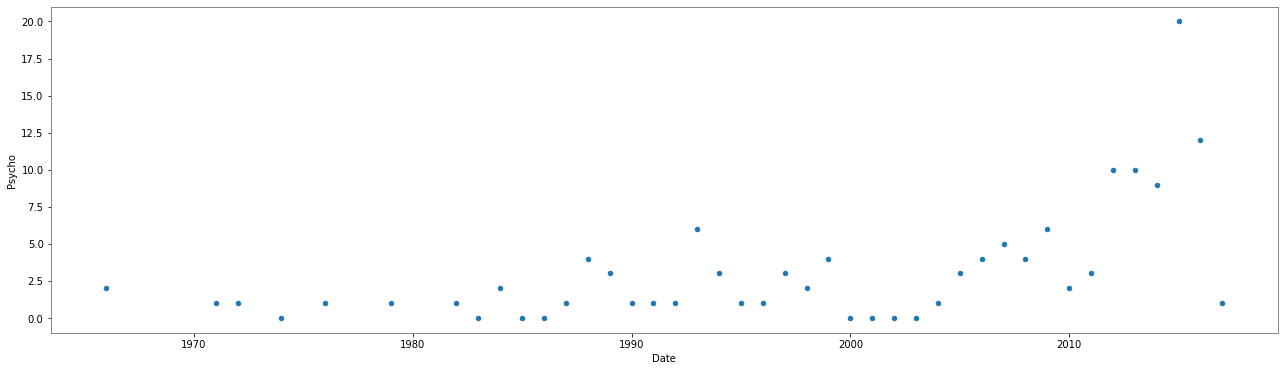

In [67]:
neworder = ['Date', 'Black racism', 'Dispute', 'Drunk', 'Psycho', 'Religious', 'Revenge', 'Unknown', 'White racism']


cause_df.plot(x='Date', y='Psycho', kind='scatter')



На закуску можно построить и scatter_matrix но, в силу особенностей наших данных, она даст нам немного

array([[<AxesSubplot:xlabel='Fatalities', ylabel='Fatalities'>,
        <AxesSubplot:xlabel='Injured', ylabel='Fatalities'>,
        <AxesSubplot:xlabel='Total victims', ylabel='Fatalities'>,
        <AxesSubplot:xlabel='Policeman Killed', ylabel='Fatalities'>,
        <AxesSubplot:xlabel='Employeed (Y/N)', ylabel='Fatalities'>],
       [<AxesSubplot:xlabel='Fatalities', ylabel='Injured'>,
        <AxesSubplot:xlabel='Injured', ylabel='Injured'>,
        <AxesSubplot:xlabel='Total victims', ylabel='Injured'>,
        <AxesSubplot:xlabel='Policeman Killed', ylabel='Injured'>,
        <AxesSubplot:xlabel='Employeed (Y/N)', ylabel='Injured'>],
       [<AxesSubplot:xlabel='Fatalities', ylabel='Total victims'>,
        <AxesSubplot:xlabel='Injured', ylabel='Total victims'>,
        <AxesSubplot:xlabel='Total victims', ylabel='Total victims'>,
        <AxesSubplot:xlabel='Policeman Killed', ylabel='Total victims'>,
        <AxesSubplot:xlabel='Employeed (Y/N)', ylabel='Total victims'>],
    

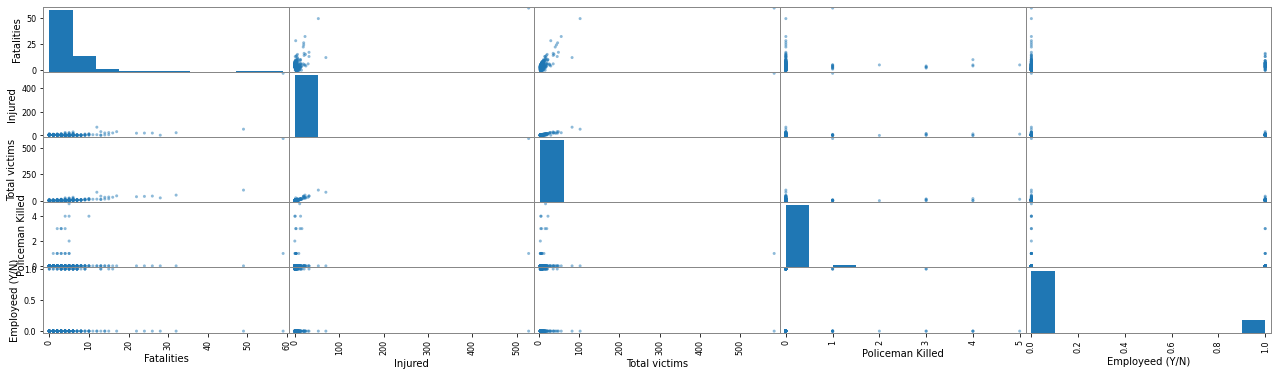

In [57]:
pd.plotting.scatter_matrix(ms_v5_df_clean)